### Create driver & Open website

In [68]:
from selenium import webdriver
from selenium .webdriver.chrome.service import Service
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium import webdriver
from tqdm.notebook import tqdm
import re
import pandas as pd
from selenium.common.exceptions import StaleElementReferenceException
import time
#import koreanize_matplotlib
#Font -> koreanize_matplotlib doesn't work in my environment
font_path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

### Open Website

In [69]:
url = "https://www.opinet.co.kr/searRgSelect.do"
driver = webdriver.Chrome(service = Service('../../../driver/chromedriver-win64/chromedriver.exe'))
driver.get(url)

### Get SI

In [70]:
# GET SI 
si = driver.find_element(By.ID,  "SIDO_NM0")  
si_options = si.find_elements(By.TAG_NAME, "option") # <option value = ""> 
si_names = [] 
for each in si_options: 
    si_names.append(each.get_attribute("value"))
si_names.remove('') ## First <optoin> element got no 'value' 
si.send_keys(si_names[0]) # -> contains "Seoul"

### GET GU 

In [71]:
gu = driver.find_element(By.ID, "SIGUNGU_NM0")  
gu_options = gu.find_elements(By.TAG_NAME, "option")
gu_names = []

for each in gu_options:
    gu_names.append(each.get_attribute("value")) ## 

gu_names.remove("")
print(len(gu_names)) # There should be 25 districts (gus)
gu.send_keys(gu_names[0]) 

25


### 서울특별시 각 구 주유소 정보가져오기 (휘발유,경유, 주유소명, 전화번호, 위치, 상표)

In [72]:
#Gu
gu = driver.find_element(By.ID, "SIGUNGU_NM0") # since Seoul contains only 'gu', I will use the variable naeded "gu" for Gu element
gu_options = gu.find_elements(By.TAG_NAME, "option")
gu_names = []

for each in gu_options:
    gu_names.append(each.get_attribute("value"))  

gu_names.remove("")
print(len(gu_names)) # needs to contain 25 Gus   
df_list = []

# select normal gasoline
driver.find_element(By.ID, "os_layer2").find_element(By.TAG_NAME,"a").click()
#----------------------Get each gu's gas stations' info (gas, disel, phone num, location, brand)-----------
for idx, each in tqdm(enumerate(gu_names)):
    gu = driver.find_element(By.ID, "SIGUNGU_NM0") 
    gu.send_keys(gu_names[idx])
 
#------------------------Now in a specific gu------------------------------------
    phoneNum_list = []
    brand_list = []
    basicInfo_ul = []
    address_list = []
    gas_price = []
    disel_price = []
    car_wash = []
    charger = []
    maintenance = []
    convinience = []
    hours = []
    station_name = []
    results = [car_wash, charger, maintenance, convinience, hours]
    
    try:
        gas_station_tbody = driver.find_element(By.ID, 'body1')#Check gas stations providng normal gas
        gasStation_tr = gas_station_tbody.find_elements(By.TAG_NAME, "tr") 
    except  StaleElementReferenceException:
         print ("element is stale!")
         time.sleep(3) # if webdriverwait&EC are performed b4 new page is loaded, it can't detect stale element (click -> term b4 new page loaded -> previous element is loaded to gas_station_tbody, if still in loading, webdriverwait&EC didn't detect )

    # <gasoline, disel price> 
    for each in gasStation_tr: 
        price = each.find_elements(By.CLASS_NAME, "price")
        gas_price.append(price[0].text)
        disel_price.append(price[1].text)
    #<station name, phone num, address, brand> 
    for idx, each in enumerate(gasStation_tr):
        each.find_element(By.TAG_NAME, "a").click()
        #<Gas station name>
        station_name.append(driver.find_element(By.ID, "os_nm").get_attribute("innerHTML")) #.txt can't be used since it's not visible
        #<phone num, address, brand> 
        info_div = driver.find_element(By.CLASS_NAME, "gis_detail_info_bcon")
        basicInfo_ul = info_div.find_element(By.TAG_NAME, "ul") # 기본정보 <li> 모음
        basicInfo_ul=(basicInfo_ul.get_attribute("innerHTML"))
        split_basicInfo = basicInfo_ul.split(':') #BrandType -> GS칼텍스, S-OIL, 알뜰주유소. 
        phoneNum_list.append(re.search("\d+-\d+-\d+",basicInfo_ul).group()) # 
        address_list.append(re.search("[가-힣]+구", basicInfo_ul).group()) #
        station_match = re.search("[a-zA-Z]+[가-힣]+", split_basicInfo[3]) # [a-zA-Z]+[가-힣]+ also includes "전화번호". For this reason, I had to narrow scope
        if station_match:
                brand_list.append(station_match.group())
        elif re.search("[a-zA-Z]+-[a-zA-Z]+", split_basicInfo[3]):
                brand_list.append(re.search("[a-zA-Z]+-[a-zA-Z]+", split_basicInfo[3]).group())
        elif re.search("[가-힣]+",  split_basicInfo[3]):
                brand_list.append(re.search("[가-힣]+", split_basicInfo[3]).group()) 
        #<Service> 
        service_div = driver.find_element(By.CLASS_NAME, 'service').find_elements(By.TAG_NAME, "img") # if not provided, 'off' included in src
        for idx, each in enumerate (service_div):
            provide = "N" if "off" in each.get_attribute("src") else "Y"
            results[idx].append(provide)

    # <DF for each gu>
    df = pd.DataFrame({"주우소" :station_name, "상표" : brand_list, "휘발유" : gas_price, "경유" : disel_price, "전화번호" :
                         phoneNum_list, "주소" : address_list, "세차장" : results[0],  "충전소": results[1],
                         "경정비" : results[2], "편의점" : results[3], "24시영업":results[4]})
    address_list = []
    phoneNum_list = []
    brand_list = []
    gas_price = []
    disel_price = [] 
    results = []
    station_name = []
    df_list.append(df)

oil_data = pd.concat(df_list)            
oil_data


<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rlawn\AppData\Local\Temp\ipykernel_15368\785163090.py:57: SyntaxWarning: invalid escape sequence '\d'
  phoneNum_list.append(re.search("\d+-\d+-\d+",basicInfo_ul).group()) #


25


0it [00:00, ?it/s]

,주우소,상표,휘발유,경유,전화번호,주소,세차장,충전소,경정비,편의점,24시영업
0,(주)보성 세곡주유소,SK에너지,1655,1553,02-445-6870,강남구,Y,N,N,N,N
1,HD현대오일뱅크㈜직영 산성셀프주유소,HD현대오일뱅크,1665,1565,02-2226-4963,강남구,Y,N,N,N,N
2,오일프러스 셀프,SK에너지,1675,1595,02-3462-5100,강남구,Y,N,Y,N,Y
3,HD현대오일뱅크㈜직영 유진주유소,HD현대오일뱅크,1679,1594,02-3462-5215,강남구,Y,N,Y,N,N
4,극동유화㈜ 개나리주유소,S-OIL,1685,1595,02-564-0186,강남구,Y,N,Y,N,Y
...,...,...,...,...,...,...,...,...,...,...,...
8,(주)기지에너지,S-OIL,1639,1539,02-2207-9419,중랑구,N,N,N,N,N
9,신내주유소,SK에너지,1652,1553,02-2207-0523,중랑구,Y,N,N,N,N
10,용마로주유소,SK에너지,1658,1538,02-439-3037,중랑구,Y,N,N,N,N
11,신일셀프주유소,SK에너지,1659,1568,02-436-3651,중랑구,Y,N,Y,N,Y


In [73]:
#######위에꺼 테스트!#####
oil_data["휘발유"] = oil_data["휘발유"].astype(float)
oil_data["경유"] = oil_data["경유"].astype(float)
oil_data.rename(columns = {"주소" : "구"}, inplace=True)
oil_data[oil_data["구"]=='금천구']

,주우소,상표,휘발유,경유,전화번호,구,세차장,충전소,경정비,편의점,24시영업
0,(주)화동유업 화동주유소,SK에너지,1613.0,1513.0,02-856-0283,금천구,Y,N,N,N,N
1,(주)백운주유소,알뜰주유소,1614.0,1514.0,02-894-8521,금천구,N,N,N,N,N
2,구광주유소,S-OIL,1615.0,1515.0,02-868-6889,금천구,Y,N,N,N,N
3,HD현대오일뱅크㈜직영 금천현대셀프주유소,HD현대오일뱅크,1644.0,1539.0,02-891-5189,금천구,Y,N,N,N,N
4,대득에너지(금천셀프주유소),GS칼텍스,1665.0,1565.0,02-805-7888,금천구,Y,N,N,Y,Y
5,현대오일뱅크㈜직영 금천제일주유소,HD현대오일뱅크,1669.0,1559.0,02-859-5426,금천구,Y,N,N,N,N
6,남서울경복에너지,HD현대오일뱅크,1675.0,1575.0,02-855-9880,금천구,N,N,N,N,N
7,SK에너지(주) 박미주유소,SK에너지,1675.0,1575.0,02-802-6749,금천구,N,N,N,N,N
8,백산주유소,S-OIL,1685.0,1595.0,02-807-3161,금천구,Y,N,Y,N,N
9,지에스칼텍스(주)일신주유소,GS칼텍스,1695.0,1595.0,02-896-5145,금천구,Y,N,N,N,N


### 시각화 각 구의 기름값 - box plot

25


C:\Users\rlawn\AppData\Local\Temp\ipykernel_15368\2716611258.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=a, y=b, data=d, palette=pvalue)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


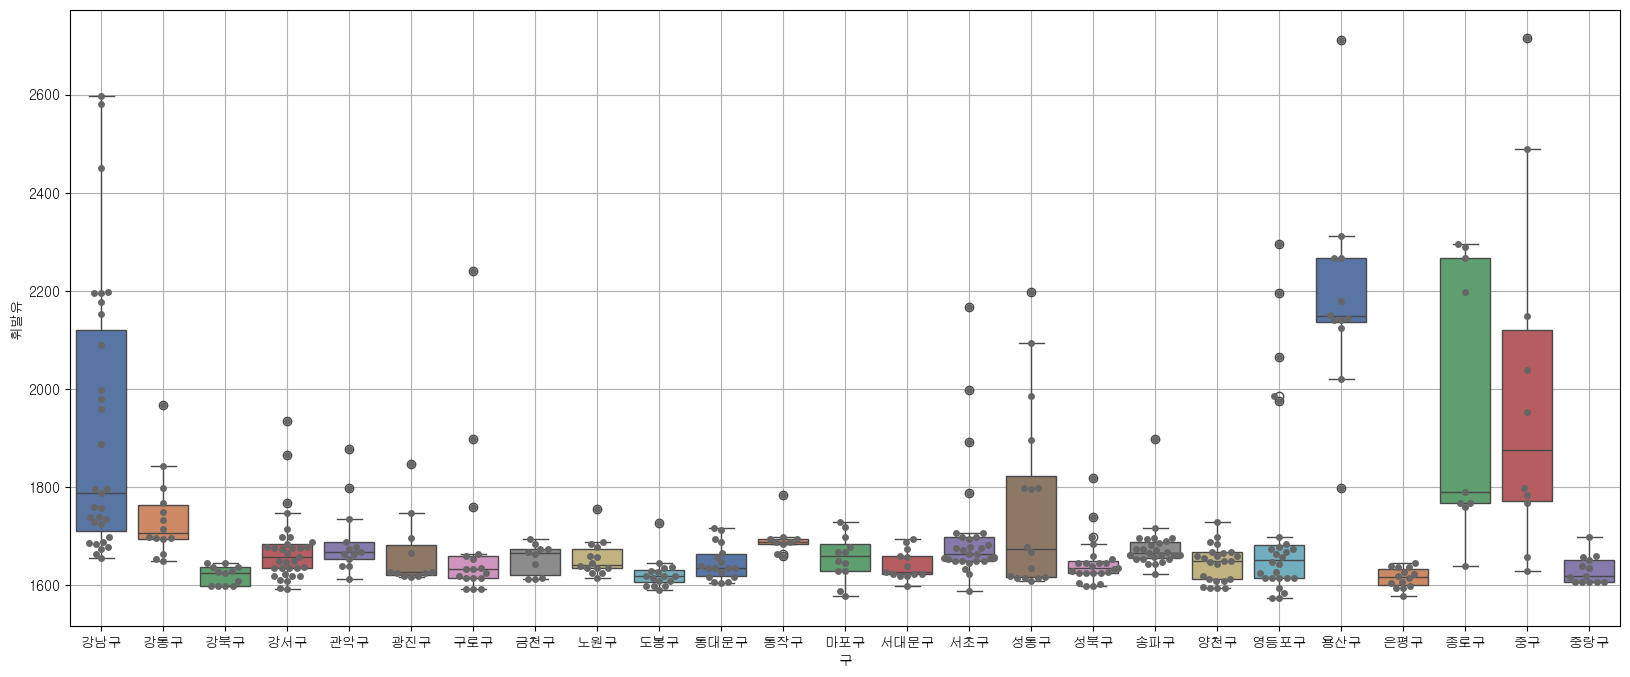

C:\Users\rlawn\AppData\Local\Temp\ipykernel_15368\2716611258.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=a, y=b, data=d, palette=pvalue)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


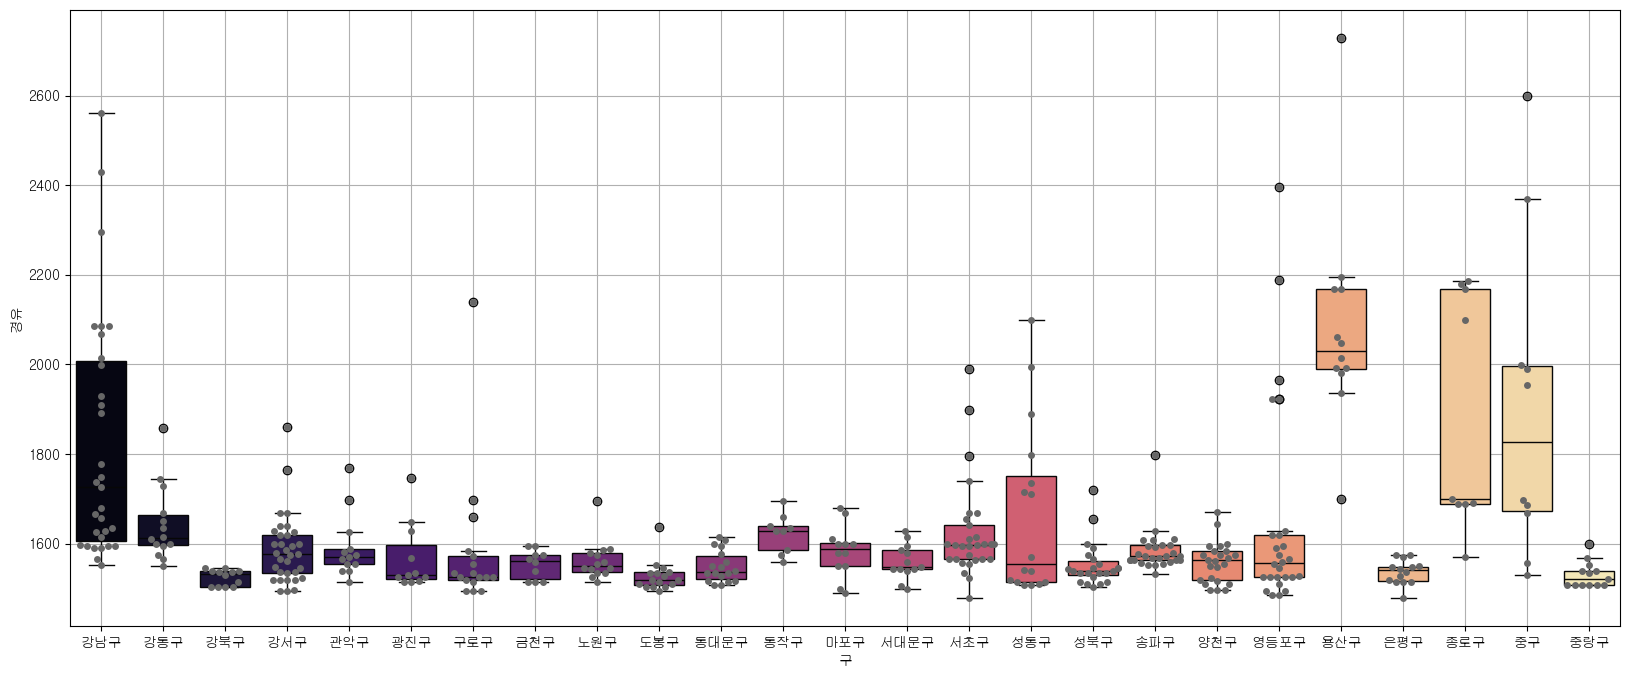

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

oil_data.reset_index(drop=True, inplace=True)
print(len(oil_data["구"].unique()))
oil_data["휘발유"] = oil_data["휘발유"].astype("float")
oil_data["경유"] = oil_data["경유"].astype("float")


#<Each gu's gasoline price>
def draw1 (a, b, d, pvalue):
    plt.figure (figsize=(20,8))
    sns.boxplot(x=a, y=b, data=d, palette=pvalue)
    sns.swarmplot(x=a, y=b,data=d, color='0.4')
    plt.grid(True)
    plt.show()

draw1 ("구", "휘발유", oil_data, "deep")
draw1 ("구", "경유", oil_data, "magma")


### which gu has more 24hrs-open gas-statoin?

C:\Users\rlawn\AppData\Local\Temp\ipykernel_15368\4011455723.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  gu_24hrs = pd.pivot_table(data = oil_data, index = "구", values="24시영업(2)", aggfunc=sum)


,24시영업(2)
구,
강남구,13
강동구,1
강북구,3
강서구,8
관악구,2
광진구,4
구로구,3
금천구,1
노원구,2


C:\Users\rlawn\AppData\Local\Temp\ipykernel_15368\4011455723.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="구", y="24시영업(2)", data = gu_24hrs, palette="bright")


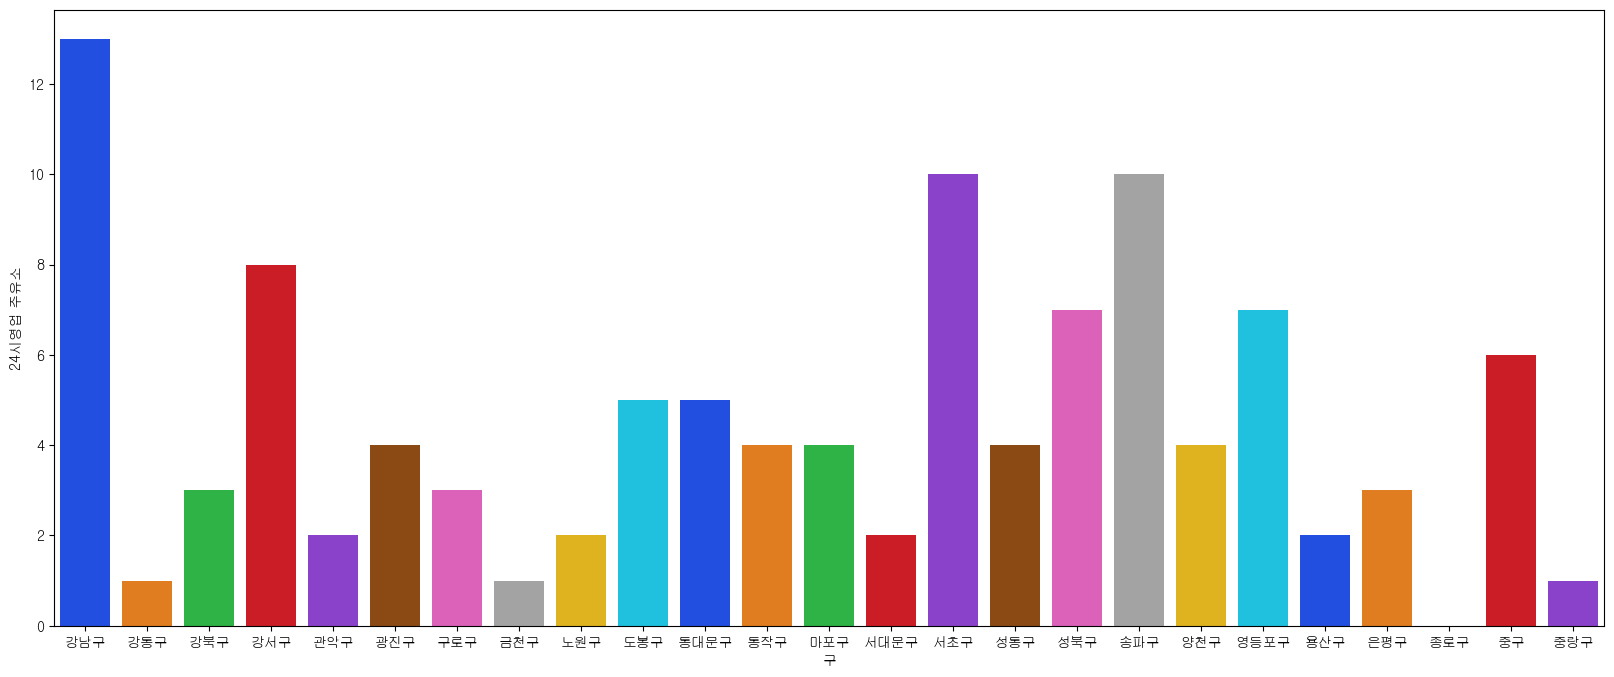

In [75]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(oil_data["24시영업"])
oil_data["24시영업(2)"] = encoder.transform(oil_data["24시영업"])
gu_24hrs = pd.pivot_table(data = oil_data, index = "구", values="24시영업(2)", aggfunc=sum)
display(gu_24hrs)
plt.figure (figsize=(20,8))
sns.barplot(x="구", y="24시영업(2)", data = gu_24hrs, palette="bright")
plt.ylabel("24시영업 주유소")
plt.show()